### imports

In [441]:
import tensorflow as tf 
import numpy as np
import pandas as pd 
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

### data preprocessing

In [442]:
df_mp = pd.read_csv('/home/april-ai/Desktop/UQ/MP_Data/materials_data_10k_cleaned.csv')

In [443]:
df_mp.head()

,nsites,composition,formula_pretty,volume,density,symmetry,material_id,structure,formation_energy_per_atom,energy_above_hull,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,3,Te2 Rh1,Te2Rh,74.021226,8.033482,"{'crystal_system': 'Trigonal', 'symbol': 'P-3m...",mp-228,"{'@module': 'pymatgen.core.structure', '@class...",-0.439840,0.0,...,0.0,0.0,0.0,0.0,152.0,225.0,73.0,176.333333,32.444444,152.0
1,24,Zn1 As2,ZnAs2,558.344218,5.121352,"{'crystal_system': 'Monoclinic', 'symbol': 'P2...",mp-7262,"{'@module': 'pymatgen.core.structure', '@class...",-0.148991,0.0,...,0.0,0.0,0.0,0.0,166.0,194.0,28.0,175.333333,12.444444,166.0
2,16,Li1 As1,LiAs,287.389201,3.784027,"{'crystal_system': 'Monoclinic', 'symbol': 'P2...",mp-7943,"{'@module': 'pymatgen.core.structure', '@class...",-0.588209,0.0,...,0.0,0.0,0.0,0.0,166.0,229.0,63.0,197.500000,31.500000,166.0
3,10,Cd1 P4,CdP4,206.572949,3.799098,"{'crystal_system': 'Monoclinic', 'symbol': 'P2...",mp-7904,"{'@module': 'pymatgen.core.structure', '@class...",-0.120743,0.0,...,0.0,0.0,0.0,0.0,2.0,194.0,192.0,40.400000,61.440000,2.0
4,16,Na1 Sb1,NaSb,477.144588,4.030018,"{'crystal_system': 'Monoclinic', 'symbol': 'P2...",mp-7944,"{'@module': 'pymatgen.core.structure', '@class...",-0.448723,0.0,...,0.0,0.0,0.0,0.0,166.0,229.0,63.0,197.500000,31.500000,166.0


In [444]:
df_mp = df_mp[(df_mp['band_gap'] > 0.2)]
y = df_mp['band_gap']

In [445]:
"""
# Define and clean inputs
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites"]
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')

#
original_indices = df_mp.index.to_numpy()
formulas = df_mp.loc[original_indices, "formula_pretty"].values

# Step 4: Feature scaling
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Step 5: Feature selection AFTER scaling
#X_selected = SelectKBest(score_func=f_regression, k=30).fit_transform(X_scaled, y)

# Step 6: Train-test split on selected features and aligned y
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, original_indices, test_size=0.2, random_state=42
)
"""

'\n# Define and clean inputs\ny = df_mp[\'band_gap\'].values\nexcluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites"]\nX = df_mp.drop(columns=excluded + ["band_gap"], errors=\'ignore\')\n\n#\noriginal_indices = df_mp.index.to_numpy()\nformulas = df_mp.loc[original_indices, "formula_pretty"].values\n\n# Step 4: Feature scaling\n#scaler = StandardScaler()\n#X_scaled = scaler.fit_transform(X)\n\n# Step 5: Feature selection AFTER scaling\n#X_selected = SelectKBest(score_func=f_regression, k=30).fit_transform(X_scaled, y)\n\n# Step 6: Train-test split on selected features and aligned y\nX_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(\n    X, y, original_indices, test_size=0.2, random_state=42\n)\n'

In [446]:
# Step 1: Extract target and drop metadata columns
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites"]
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')

# Keep track of indices and formulas (optional, for post-analysis)
original_indices = df_mp.index.to_numpy()
formulas = df_mp.loc[original_indices, "formula_pretty"].values

# Step 2: Train/test split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, original_indices, test_size=0.2, random_state=42
)

# Step 3: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Feature selection (optional but recommended)
# selector = SelectKBest(score_func=f_regression, k=100)
# X_train_selected = selector.fit_transform(X_train_scaled, y_train)
# X_test_selected = selector.transform(X_test_scaled)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).ravel()


In [447]:
def gaussian_nll(y_true, y_pred):
    """
    A mathematically complete Gaussian Negative Log-Likelihood loss.
    """
    # Ensure y_true is a float and flattened
    y_true = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)

    # Extract the mean and log-variance from the model's predictions
    mu = y_pred[:, 0]
    log_var = y_pred[:, 1]
    
    # The precision term (1 / variance)
    precision = tf.exp(-log_var)
    
    # The log determinant term and the squared error term
    loss = log_var + (y_true - mu)**2 * precision
    
    # Add the constant and scale by 0.5
    loss = 0.5 * (tf.math.log(2. * np.pi) + loss)
    
    return tf.reduce_mean(loss)

In [448]:
def model(input_dim = 1, seed = 42):
    """
    Defines Monte Carlo Dropout model for regression with uncertainity 

    Args: 
        input_dim (int): NUmber of input features
        seed (int): Random seed for reproducibility

    Returns: 
        compiled Keras model 
    """
    tf.random.set_seed(seed)

    model = Sequential([
        Dense(256, input_shape=(input_dim,)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(64),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),
        Dense(2)  # [mean, log(variance)]
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss = gaussian_nll)

    return model


def train(x, y, model, x_val=None, y_val=None, epochs=100):
    history = model.fit(x, y,
                        validation_data=(x_val, y_val) if x_val is not None else None,
                        batch_size=32,
                        epochs=epochs,
                        verbose=1)
    return model, history


def predict(model, x, samples = 20): 
    '''
    Args:
        model: The trained keras model
        x: the input tensor with shape [N, M]
        samples: the number of monte carlo samples to collect
    Returns:
        y_mean: The expected value of our prediction
        y_std: The standard deviation of our prediction
    '''

    mu_arr = []
    si_arr = []

    for t in range(samples):
        y_pred = model(x, training=True)
        mu = y_pred[:, 0]
        si = y_pred[:, 1]

        mu_arr.append(mu)
        si_arr.append(si)

    mu_arr = np.array(mu_arr)
    si_arr = np.array(si_arr)
    var_arr = np.exp(si_arr)

    y_mean = np.mean(mu_arr, axis=0)
    y_variance = np.mean(var_arr + mu_arr**2, axis=0) - y_mean**2
    y_std = np.sqrt(y_variance)
    
    return y_mean, y_std


In [449]:
# Define and train model
input_dim = X_train_scaled.shape[1]
mcd_model = model(input_dim=input_dim, seed=42)  # uses your improved model()

# Train the model
mcd_model, history = train(X_train_scaled, y_train_scaled, mcd_model, 
                           x_val=X_test_scaled, y_val=y_test_scaled, epochs=100)





Epoch 1/100


/home/april-ai/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.9787 - val_loss: 1.2709
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5992 - val_loss: 1.2474
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5419 - val_loss: 1.2577
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3806 - val_loss: 1.1716
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3099 - val_loss: 1.1225
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2595 - val_loss: 1.1112
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2014 - val_loss: 1.0829
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1540 - val_loss: 0.9777
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1178 - val_loss: 0.9700
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0805 - val_loss: 0.9256
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9981 - val_loss: 0.9071
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9722 - val_l

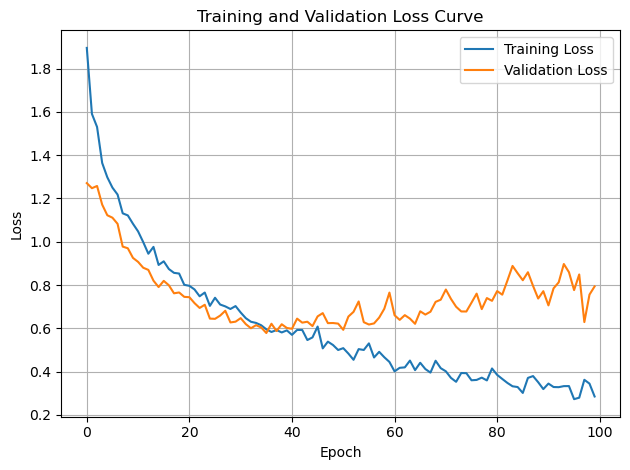

In [450]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [451]:
# Make predictions with uncertainty (in scaled space)
y_pred_mean, y_pred_std = predict(mcd_model, X_test_scaled, samples=50)

# Inverse-transform predictions and std to original scale
y_pred_mean_orig = y_scaler.inverse_transform(y_pred_mean.reshape(-1, 1)).ravel()
y_pred_std_orig = y_pred_std * y_scaler.scale_[0]  # std scales by the scaler's scale

# Calculate R² in original space
r2 = r2_score(y_test, y_pred_mean_orig)
print("R² score:", r2)

R² score: 0.5479119705717193


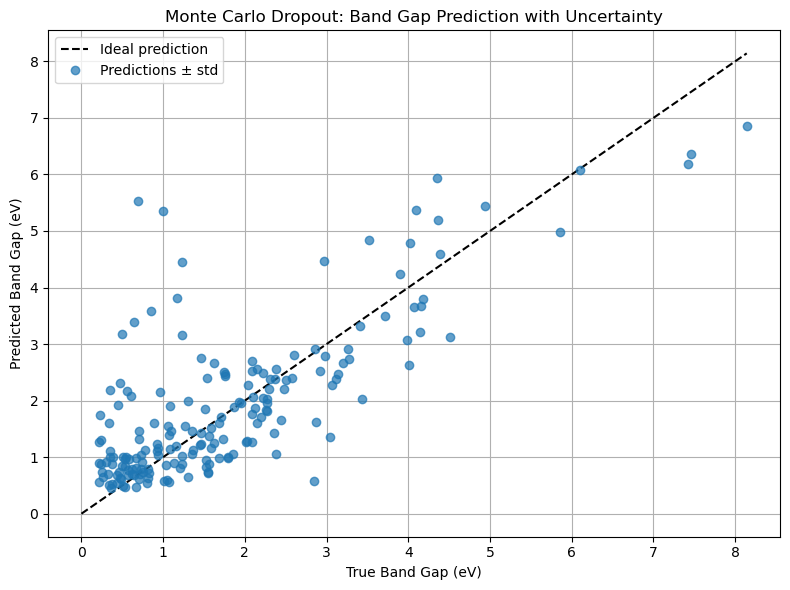

In [452]:
plt.figure(figsize=(8, 6))
plt.errorbar(y_test, y_pred_mean_orig, fmt='o', alpha=0.7, label='Predictions ± std')
plt.plot([0, max(y_test)], [0, max(y_test)], 'k--', label='Ideal prediction')
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Monte Carlo Dropout: Band Gap Prediction with Uncertainty")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

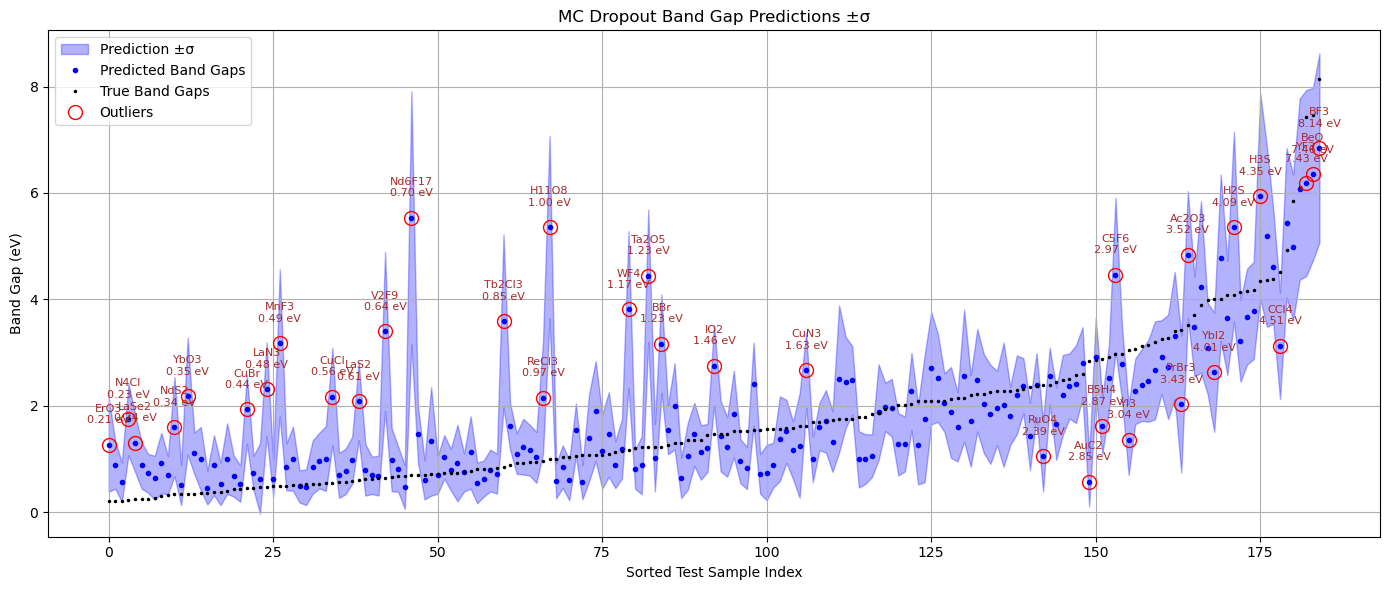

In [453]:
# Inverse-transform predictions and std to original scale
y_pred_mean_orig = y_scaler.inverse_transform(y_pred_mean.reshape(-1, 1)).ravel()
y_pred_std_orig = y_pred_std * y_scaler.scale_[0]

# Convert predictions and uncertainties to arrays
y_true = np.array(y_test)
y_predicted = np.array(y_pred_mean_orig)
y_std_dev = np.array(y_pred_std_orig)

# Sort by true band gap values
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_predicted[sorted_idx]
y_std_sorted = y_std_dev[sorted_idx]

# Confidence interval (±σ)
lower = y_pred_sorted - y_std_sorted
upper = y_pred_sorted + y_std_sorted

# Optional: retrieve formulas for annotation
formulas = df_mp.loc[idx_test, "formula_pretty"].values
formulas_sorted = formulas[sorted_idx]

# Calculate prediction error and identify outliers
errors = np.abs(y_true_sorted - y_pred_sorted)
outlier_mask = errors > 1.0  # adjust threshold as needed
outlier_indices = np.where(outlier_mask)[0]

# Plot
plt.figure(figsize=(14, 6))

# Confidence interval band
plt.fill_between(range(len(y_true_sorted)), lower, upper, alpha=0.3, label='Prediction ±σ', color='blue')

# Predicted mean
plt.plot(y_pred_sorted, 'o', markersize=3, label='Predicted Band Gaps', color='blue')

# True values
plt.plot(y_true_sorted, 'k.', markersize=3, label='True Band Gaps')

# Outliers
plt.plot(outlier_indices, y_pred_sorted[outlier_mask], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers with formula and true band gap
for i in outlier_indices:
    plt.text(i, y_pred_sorted[i] + 0.4, f"{formulas_sorted[i]}\n{y_true_sorted[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

# Final formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("MC Dropout Band Gap Predictions ±σ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Log transformed data

In [454]:
def model_log(input_dim = 1, seed = 42):
    """
    Defines Monte Carlo Dropout model for regression with uncertainity 

    Args: 
        input_dim (int): NUmber of input features
        seed (int): Random seed for reproducibility

    Returns: 
        compiled Keras model 
    """
    tf.random.set_seed(seed)
    """
    model = Sequential([
        Dense(256, input_shape=(input_dim, )),  
        Activation('relu'), 
        Dropout(0.3),
        Dense(128), 
        Activation('relu'), 
        Dropout(0.3), 
        Dense(128), 
        Activation('relu'), 
        Dropout(0.3), 
        Dense(64), 
        Activation('relu'), 
        Dropout(0.3), 
        Dense(2)



    ])

    """
    
    model = Sequential([
        Dense(256, input_shape=(input_dim,)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(64),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),
        Dense(2)  # [mean, log(variance)]
    ])
    
   
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss = gaussian_nll)

    return model




In [455]:
# Step 1: Extract features and log-transform target
y = np.log1p(df_mp['band_gap'].values)  # log(1 + band_gap)
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites"]
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')

# Step 2: Train/test split
original_indices = df_mp.index.to_numpy()
formulas = df_mp.loc[original_indices, "formula_pretty"].values

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, original_indices, test_size=0.2, random_state=42
)

# Step 3: Scale and select features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#selector = SelectKBest(score_func=f_regression, k=30)
#X_train_selected = selector.fit_transform(X_train_scaled, y_train)
#X_test_selected = selector.transform(X_test_scaled)


In [456]:
input_dim = X_train_scaled.shape[1]
mcd_model = model_log(input_dim=input_dim, seed=42)
mcd_model, history = train(
    X_train_scaled, y_train,
    model=mcd_model,
    x_val=X_test_scaled,
    y_val=y_test,
    epochs=100
)



Epoch 1/100


/home/april-ai/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.4693 - val_loss: 1.3300
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6644 - val_loss: 1.2569
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5161 - val_loss: 1.2557
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4829 - val_loss: 1.2259
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3825 - val_loss: 1.2068
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2605 - val_loss: 1.0333
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1616 - val_loss: 0.9618
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1325 - val_loss: 1.0173
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0809 - val_loss: 0.9001
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9784 - val_loss: 0.8370
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0018 - val_loss: 0.8518
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9781 - val_l

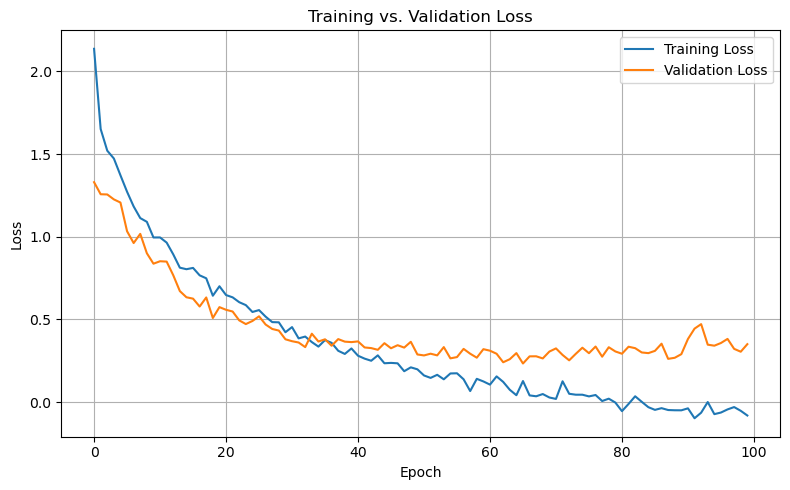

In [457]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [471]:
# Predict (log space)
y_pred_log, y_std_log = predict(mcd_model, X_test_scaled, samples=50)

# Invert log1p transformation
y_pred = np.expm1(y_pred_log)
y_std = np.expm1(y_pred_log + y_std_log) - y_pred  # Approximate std in original space
y_true = np.expm1(y_test)

# Calculate R² in original space
r2 = r2_score(y_true, y_pred)
print("R² score:", r2)


R² score: 0.608639652399954


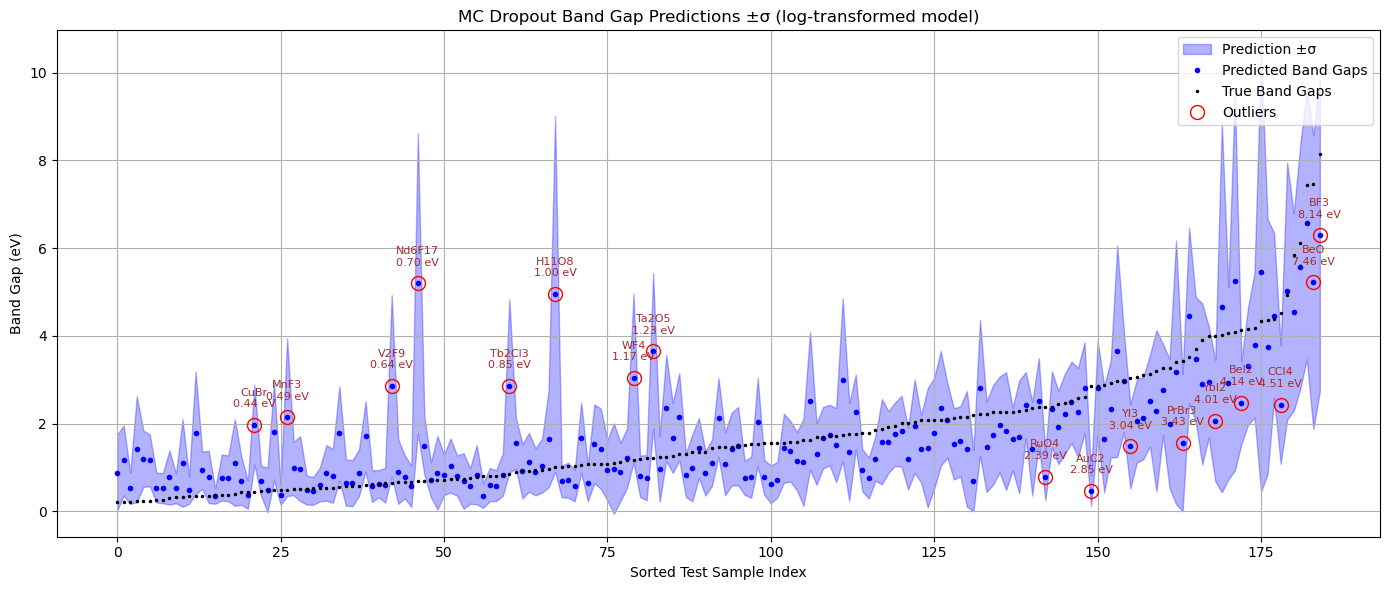

In [459]:
# Sort by true values
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]
y_std_sorted = y_std[sorted_idx]

# Confidence band
lower = y_pred_sorted - y_std_sorted
upper = y_pred_sorted + y_std_sorted

# Formulas for annotation
formulas_sorted = df_mp.loc[idx_test, "formula_pretty"].values[sorted_idx]

# Identify outliers
errors = np.abs(y_true_sorted - y_pred_sorted)
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]

# Plot
plt.figure(figsize=(14, 6))
plt.fill_between(range(len(y_true_sorted)), lower, upper, alpha=0.3, label='Prediction ±σ', color='blue')
plt.plot(y_pred_sorted, 'o', markersize=3, label='Predicted Band Gaps', color='blue')
plt.plot(y_true_sorted, 'k.', markersize=3, label='True Band Gaps')
plt.plot(outlier_indices, y_pred_sorted[outlier_mask], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers
for i in outlier_indices:
    plt.text(i, y_pred_sorted[i] + 0.4, f"{formulas_sorted[i]}\n{y_true_sorted[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("MC Dropout Band Gap Predictions ±σ (log-transformed model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
